In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import skew

In [100]:
def removeColumns(file):
    df = pd.read_csv(file)
    columns_to_keep = ['S.No.','CITY 1', 'CITY 2',
                       'PASSENGERS TO CITY 2', 'PASSENGERS FROM CITY 2']
    df = df[columns_to_keep]

    df.to_csv(file, index=False)


In [101]:
def replace_with_mean_or_median(file,column):
        df = pd.read_csv(file)

        df[column] = df[column].replace(',', '', regex=True)
        df.replace('-', np.nan, inplace=True)

        #  converting the values in the specified column to a numeric data type
        #  and any values that cannot be converted will be replaced with NaN values
        #  This ensures that we're able to calculate the mean without any type errors.
        df[column] = pd.to_numeric(df[column], errors='coerce')

        # Compute the skewness of the data
        skewness = skew(df[column])

        # Decide which measure of central tendency to use based on the skewness
        # (mean or median) ignoring NaN values
        if abs(skewness) < 1:
                # The data is positively skewed, so we should use the mean.
                mean_or_median = df[column].mean(skipna=True)
        elif skewness > 1:
                # The data is positively skewed, so we should use the median.
                mean_or_median = df[column].median(skipna=True)
        else:
                # The data is negatively skewed, so we should use the median.
                mean_or_median = df[column].median(skipna=True)

        # Replace NaN values with the calculated mean
        df[column].fillna(mean_or_median, inplace=True)
        df[column] = df[column].astype(int)
        df.to_csv(file, index=False)

In [102]:
def dataCleansing(file):

    removeColumns(file)
    replace_with_mean_or_median(file,'PASSENGERS TO CITY 2')
    replace_with_mean_or_median(file,'PASSENGERS FROM CITY 2')

    df = pd.read_csv(file)

    avg_passenger = 110
    df['PASSENGERS TO CITY 2'] = (
        df['PASSENGERS TO CITY 2'] // avg_passenger)+1
    df['PASSENGERS FROM CITY 2'] = (
        df['PASSENGERS FROM CITY 2'] // avg_passenger)+1
    df['TOTAL AVG FLIGHTS'] = df['PASSENGERS TO CITY 2'] + \
        df['PASSENGERS FROM CITY 2']
    df = df.rename(columns={'PASSENGERS TO CITY 2': 'AVG FLIGHTS TO CITY 2',
                   'PASSENGERS FROM CITY 2': 'AVG FLIGHTS FROM CITY 2'})
    df.to_csv(file, index=False)


In [103]:
def func1(file, month):

    dataCleansing(file)
    df = pd.read_csv(file)

    column_max = df['TOTAL AVG FLIGHTS'].max()
    max_row = df[df['TOTAL AVG FLIGHTS'] == column_max]
    print(f"Busiest route in {month}:")
    print(max_row[['CITY 1', 'CITY 2', 'TOTAL AVG FLIGHTS']])

    # finding total arriving flights in a particular city
    arrival = {}
    with open(file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        count = 0
        for row in csvreader:
            #         removing 1st line
            if not count:
                count += 1
                continue
            #     for city1
            if row[1] not in arrival:
                arrival[row[1]] = int(row[4])
            else:
                arrival[row[1]] += int(row[4])
        #     for city2
            if row[2] not in arrival:
                arrival[row[2]] = int(row[3])
            else:
                arrival[row[2]] += int(row[3])
    # print(arrival)

    # finding total departuring flights from a particular city
    departure = {}
    with open(file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        count = 0
        for row in csvreader:
            #     removing 1st line
            if not count:
                count += 1
                continue
            #     for city1
            if row[1] not in departure:
                departure[row[1]] = int(row[3])
            else:
                departure[row[1]] += int(row[3])
        #     for city2
            if row[2] not in departure:
                departure[row[2]] = int(row[4])
            else:
                departure[row[2]] += int(row[4])
    # print(departure)

    cities = list(arrival.keys())
    total_traffic = np.array(list(arrival.values())) + \
        np.array(list(departure.values()))
    # print(cities)
    # print(total_traffic)

    major_cities_traffic = sorted(
        enumerate(total_traffic), key=lambda x: x[1], reverse=True)[:7]
    # print(major_cities_traffic)
    index = []
    temp = []
    for i, value in major_cities_traffic:
        index.append(i)
        temp.append(value)
    major_cities_traffic = temp
    # print(index)
    sum = 0
    for i in range(len(total_traffic)):
        if i not in index:
            sum += total_traffic[i]

    major_cities_traffic.append(sum)
    # print(major_cities_traffic)
    major_cities = [cities[i] for i in index]
    major_cities.append('Other Cities')
    # print(major_cities)

    # Citywise Traffic piechart
    plt.figure(figsize=(15, 15))
    wedges, labels, x = plt.pie(
        major_cities_traffic, labels=major_cities, autopct='%1.2f%%',textprops={'fontsize': 13})

    for label in labels:
        label.set_fontsize(15)

    plt.title(f"City-wise Traffic ({month})")
    plt.show()

    new_major_cities = [major_cities[x] for x in range(len(major_cities)-1)]
    plt.figure(figsize=(10, 10))
    # Citywise arrival piechart
    new_arrival = [arrival[x] for x in new_major_cities]
    plt1 = plt.subplot(1, 2, 1)
    plt.pie(new_arrival, labels=new_major_cities, autopct='%1.2f%%')
    plt.title(f"City-wise Arrival in major cities ({month})")

    # Citywise departure piechart
    new_departure = [departure[x] for x in new_major_cities]
    plt2 = plt.subplot(1, 2, 2)
    plt.pie(new_departure, labels=new_major_cities, autopct='%1.2f%%')
    plt.title(f"City-wise Departure in major cities ({month})")
    plt.show()

    df.to_csv(file, index=False)
    # df.head()


Busiest route in January 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
326  DELHI  MUMBAI               1922


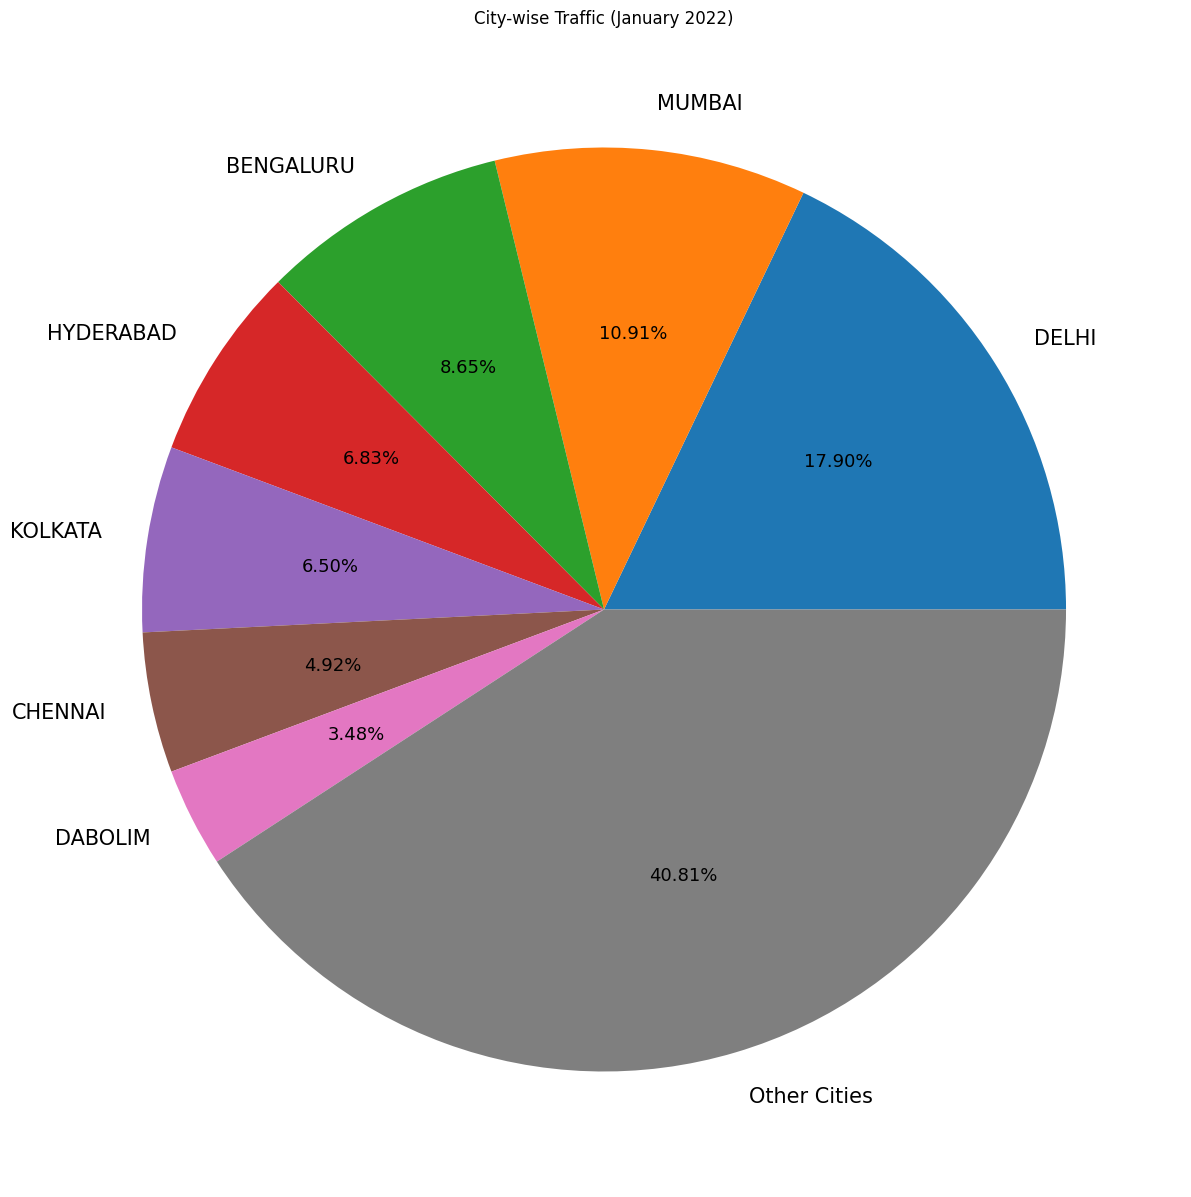

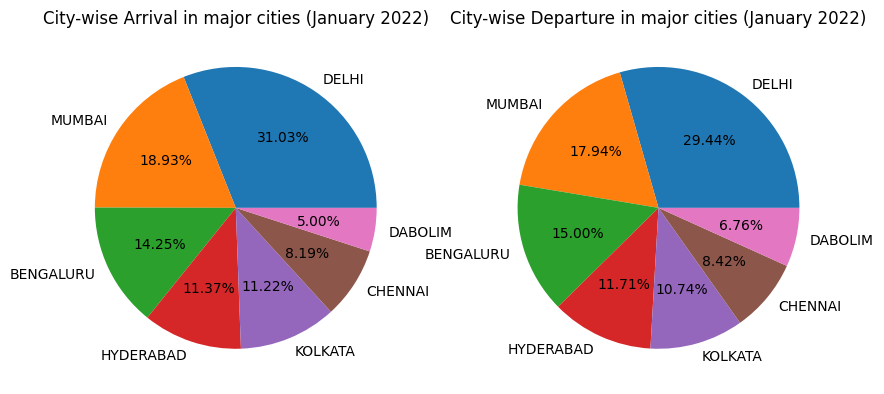

In [104]:
func1('january2022.csv','January 2022')

Busiest route in February 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
298  DELHI  MUMBAI               2994


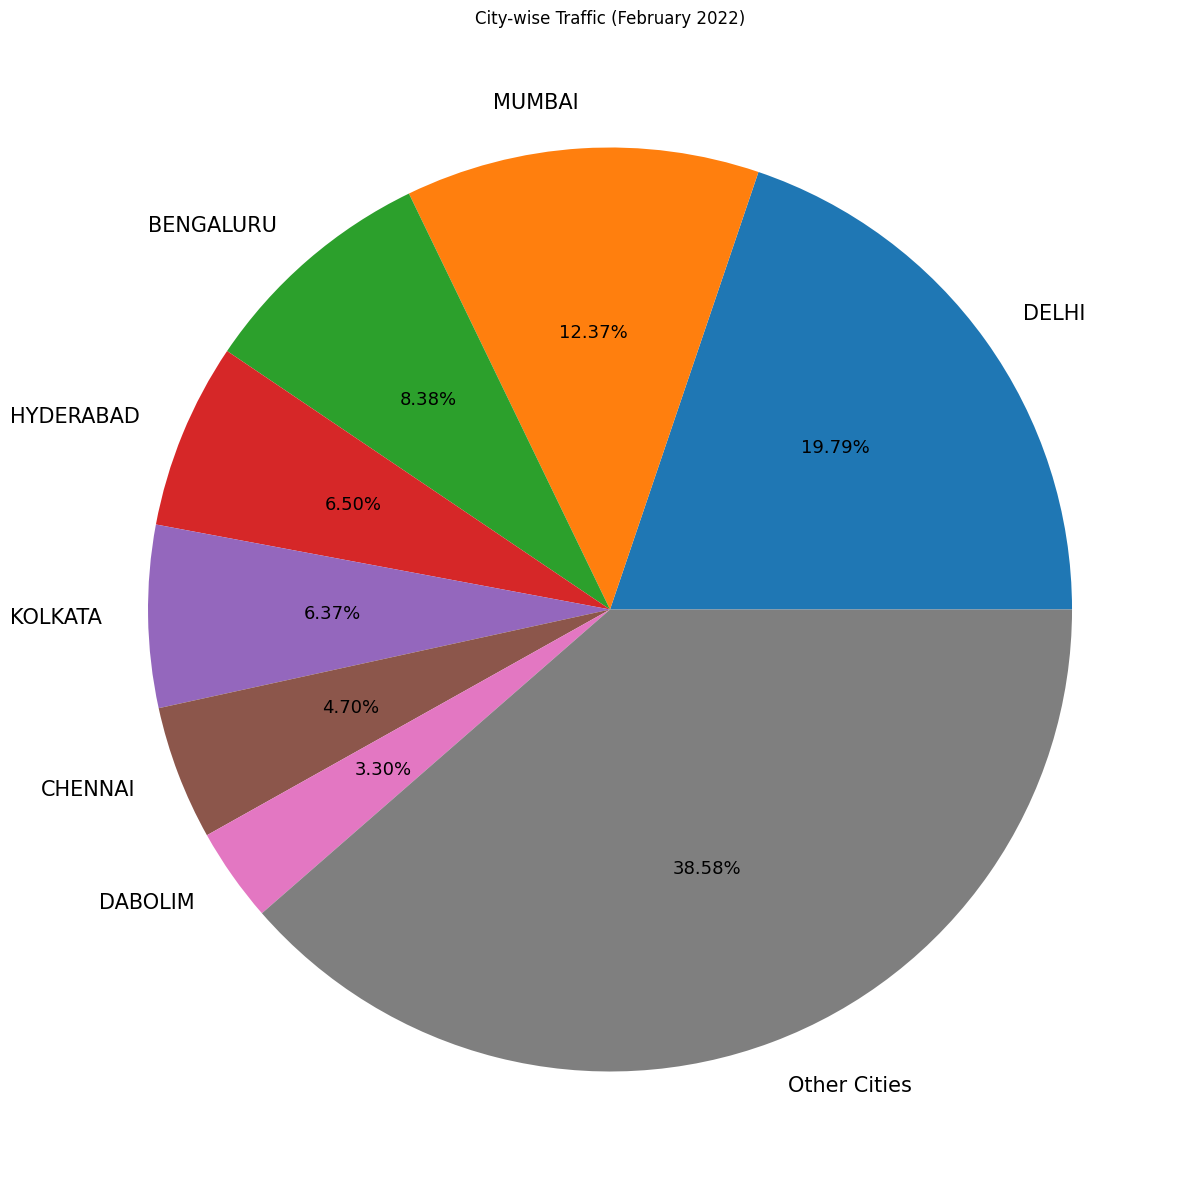

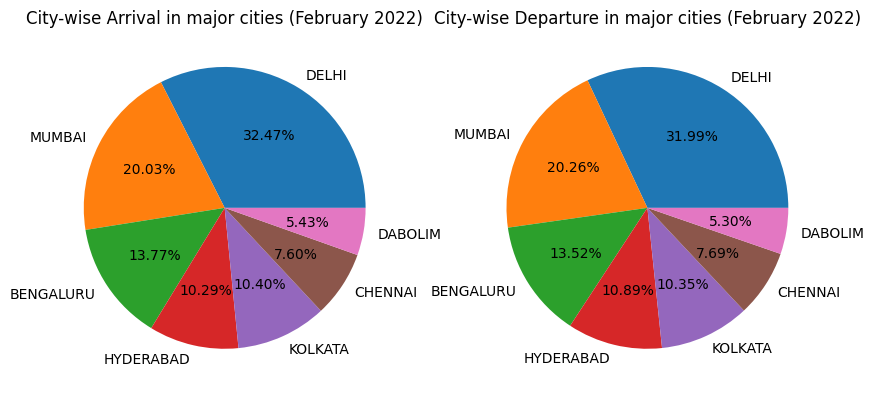

In [105]:
func1('feb2022.csv','February 2022')

Busiest route in March 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
332  DELHI  MUMBAI               4089


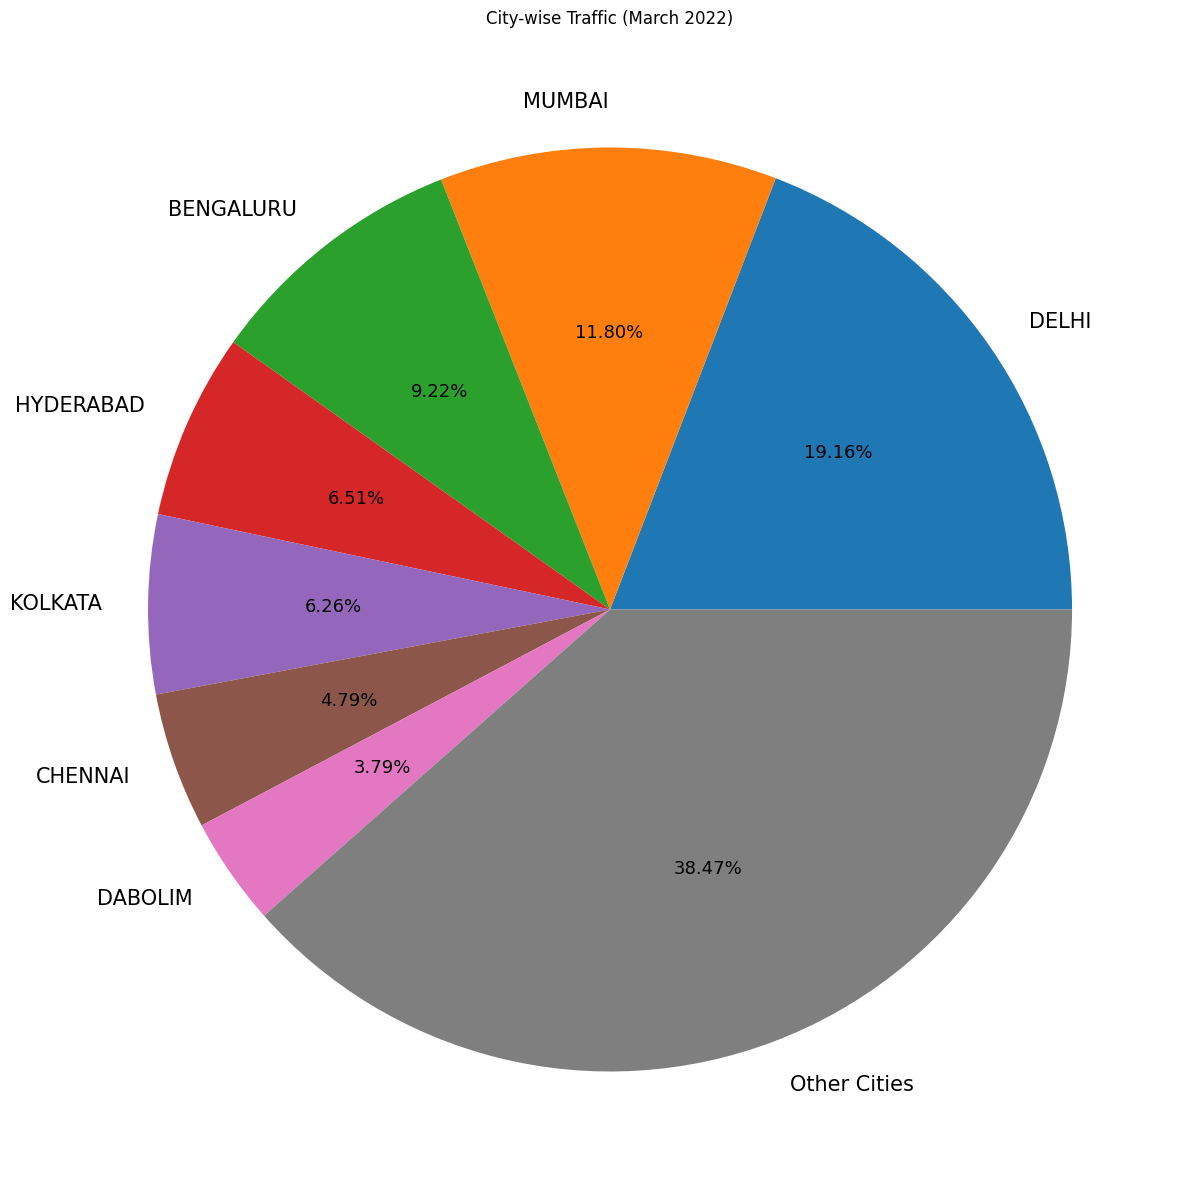

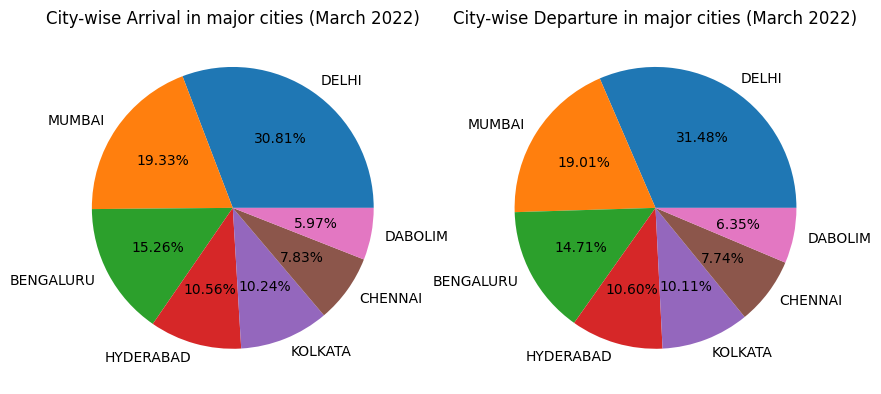

In [106]:
func1('march2022.csv','March 2022')

Busiest route in April 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
320  DELHI  MUMBAI               4029


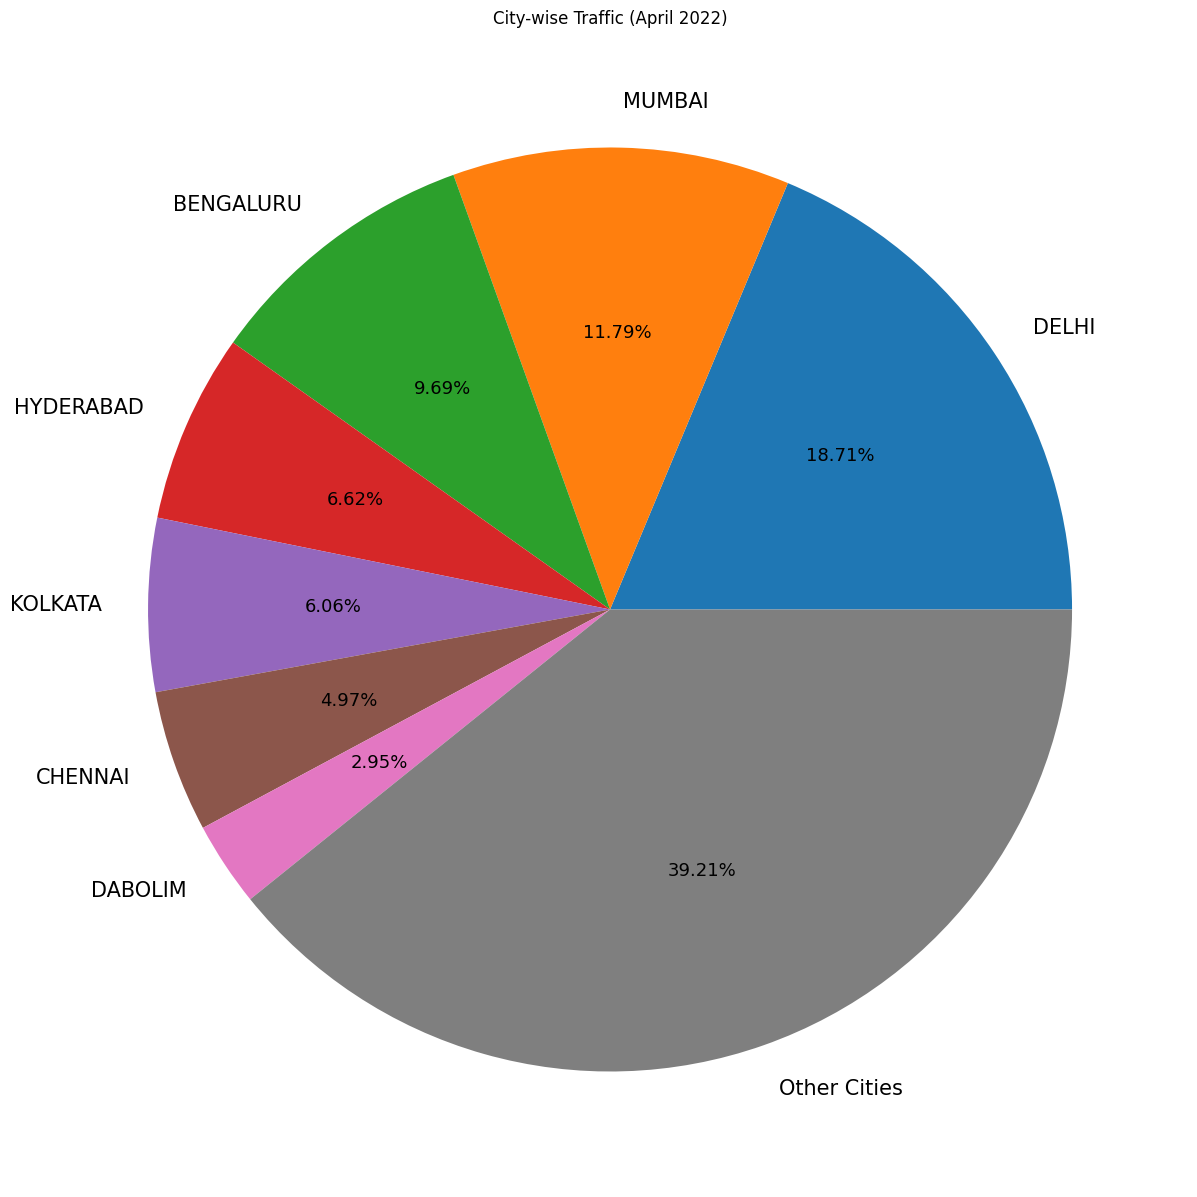

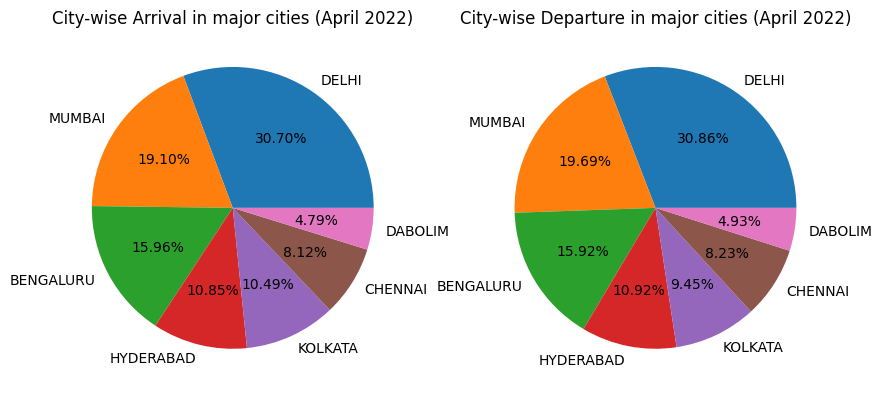

In [107]:
func1('april2022.csv','April 2022')

Busiest route in May 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
332  DELHI  MUMBAI               4650


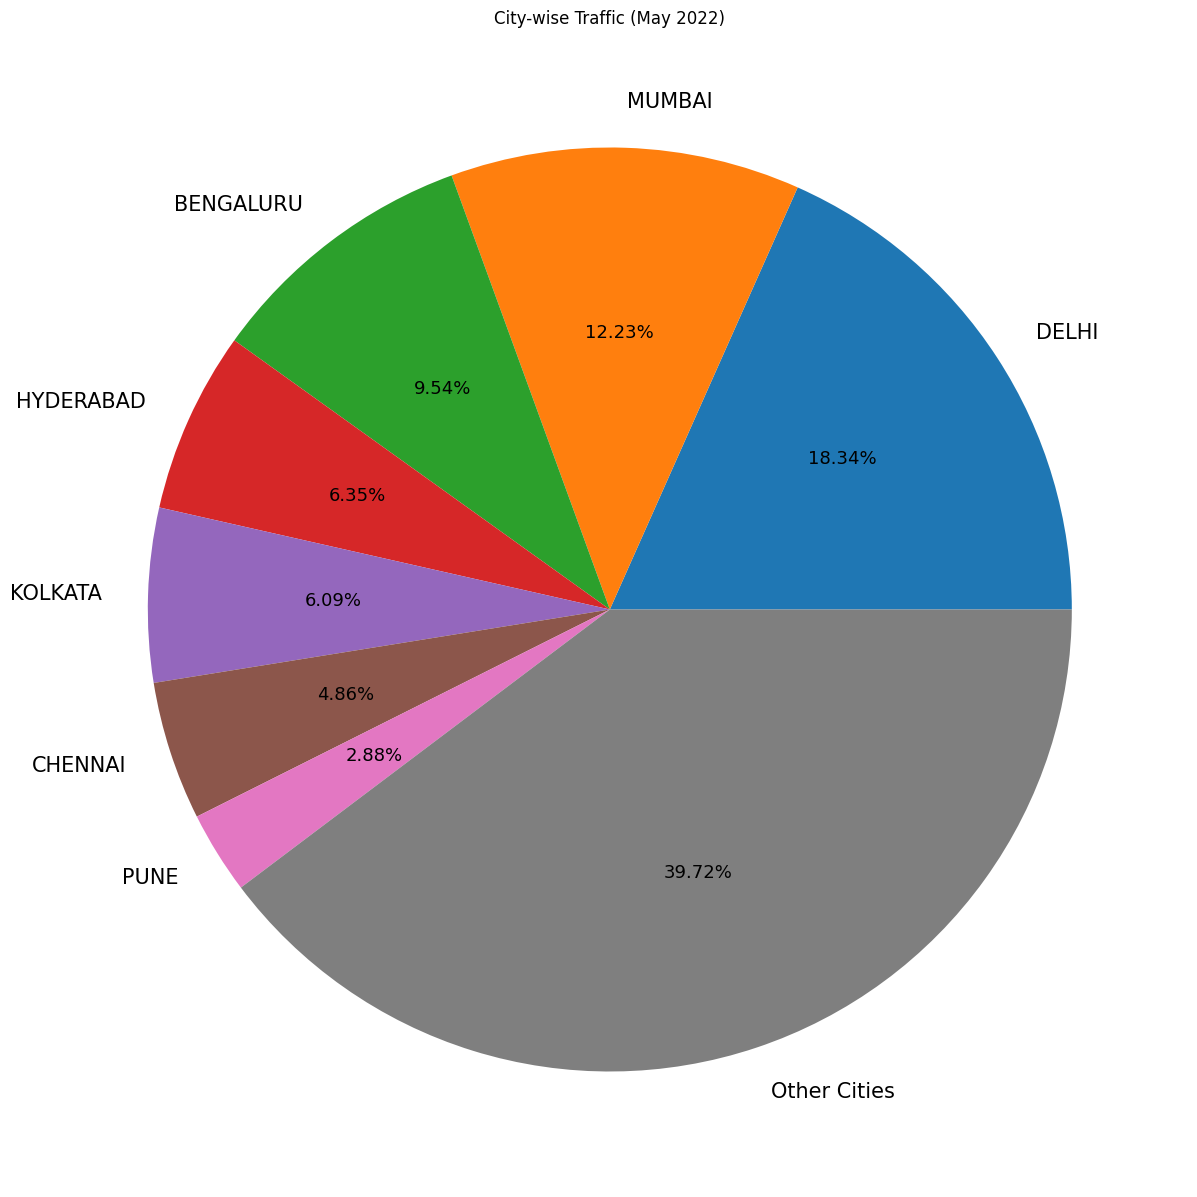

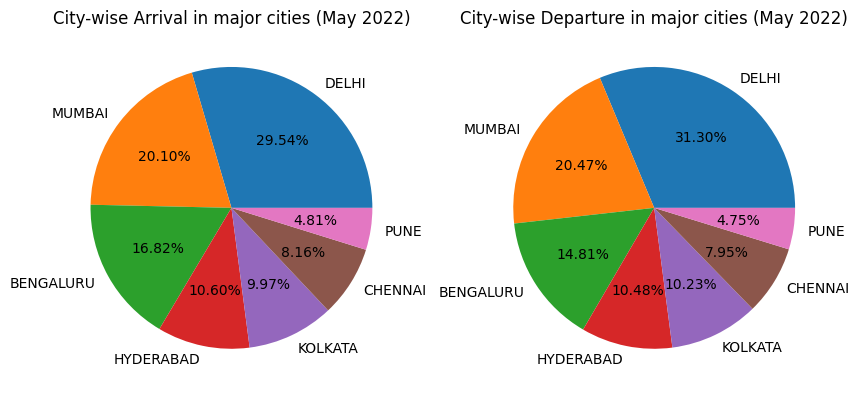

In [108]:
func1('may2022.csv','May 2022')

Busiest route in June 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
339  DELHI  MUMBAI               3683


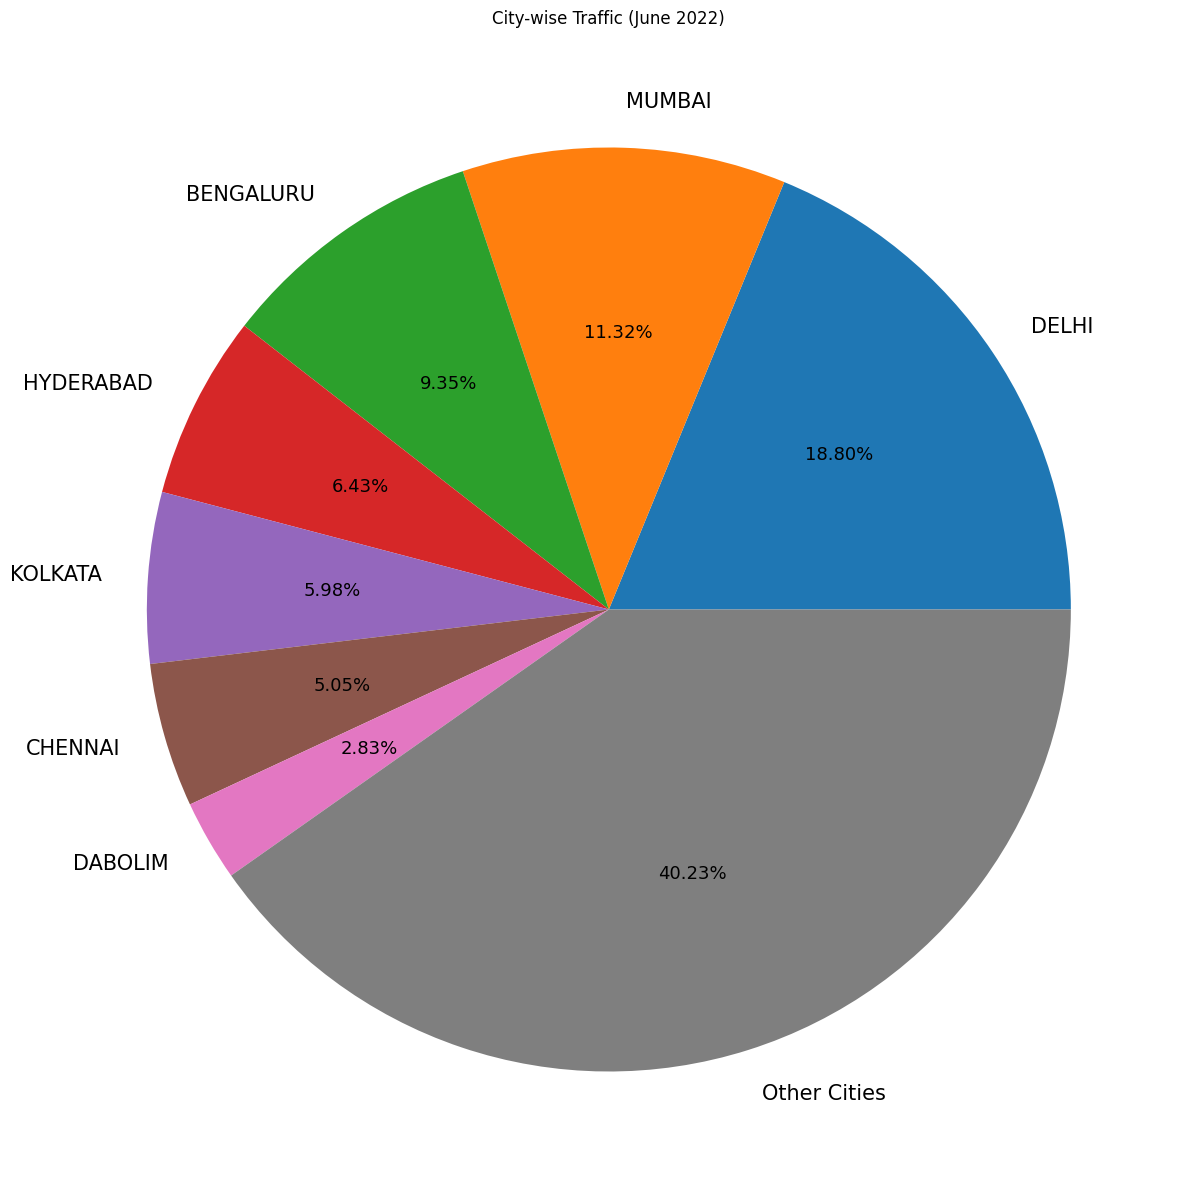

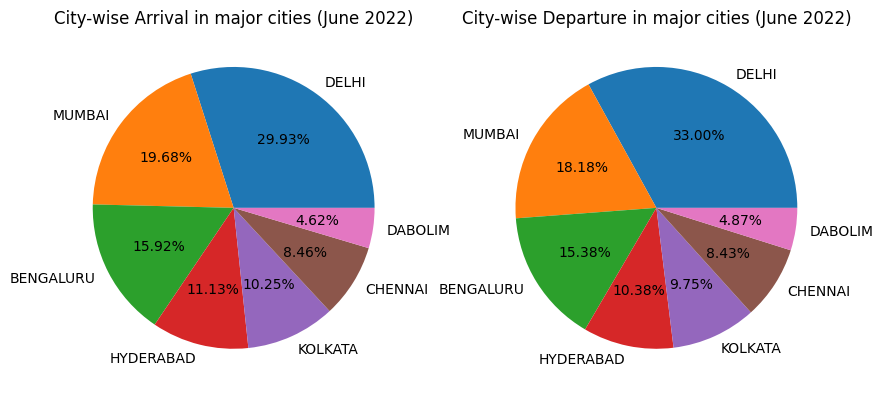

In [109]:
func1('june2022.csv','June 2022')

Busiest route in July 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
264  DELHI  MUMBAI               3399


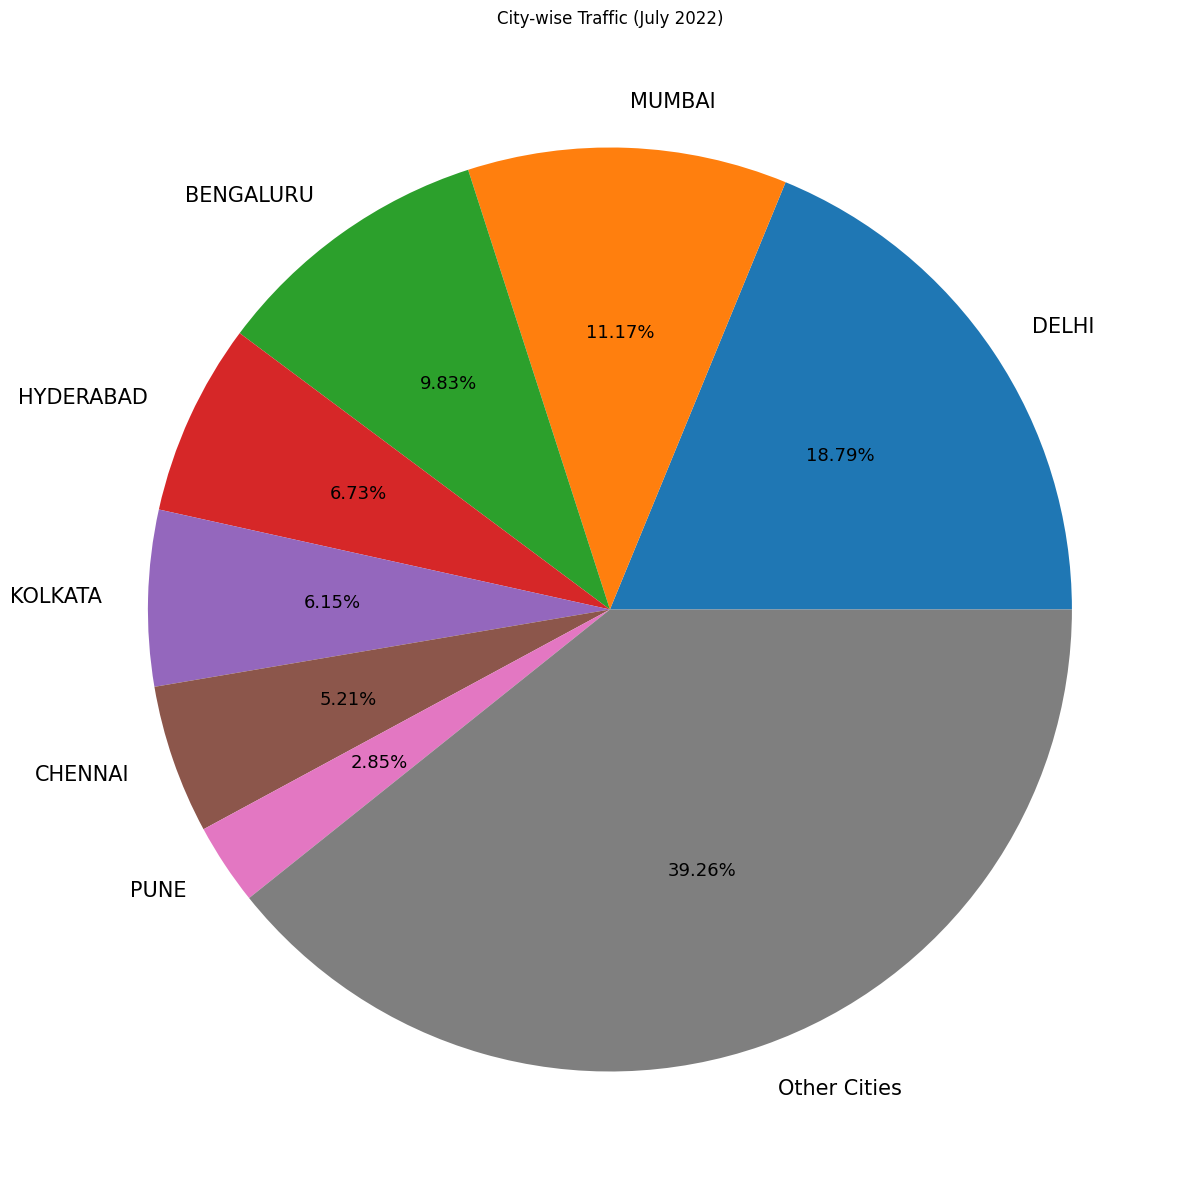

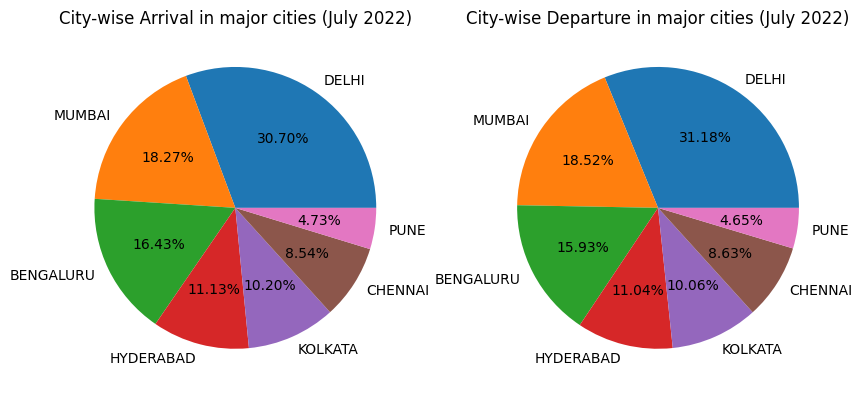

In [110]:
func1('july2022.csv','July 2022')

Busiest route in August 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
259  DELHI  MUMBAI               3794


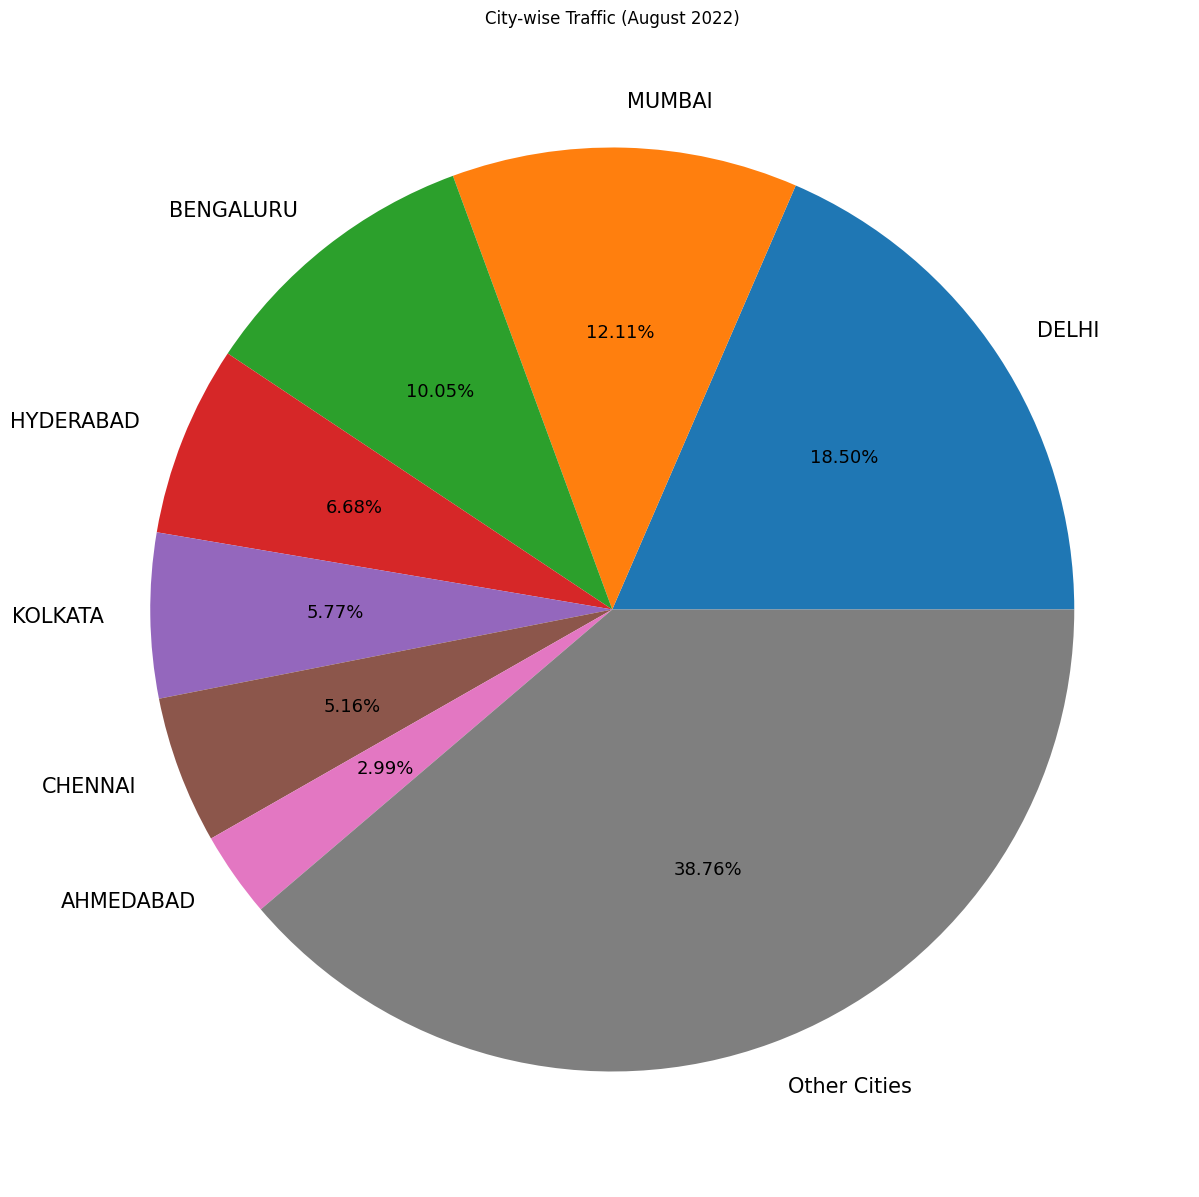

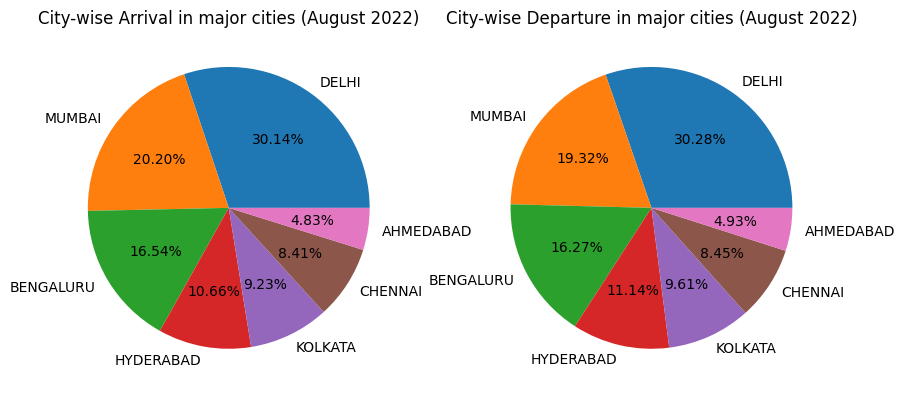

In [111]:
func1('august2022.csv','August 2022')

Busiest route in September 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
260  DELHI  MUMBAI               3983


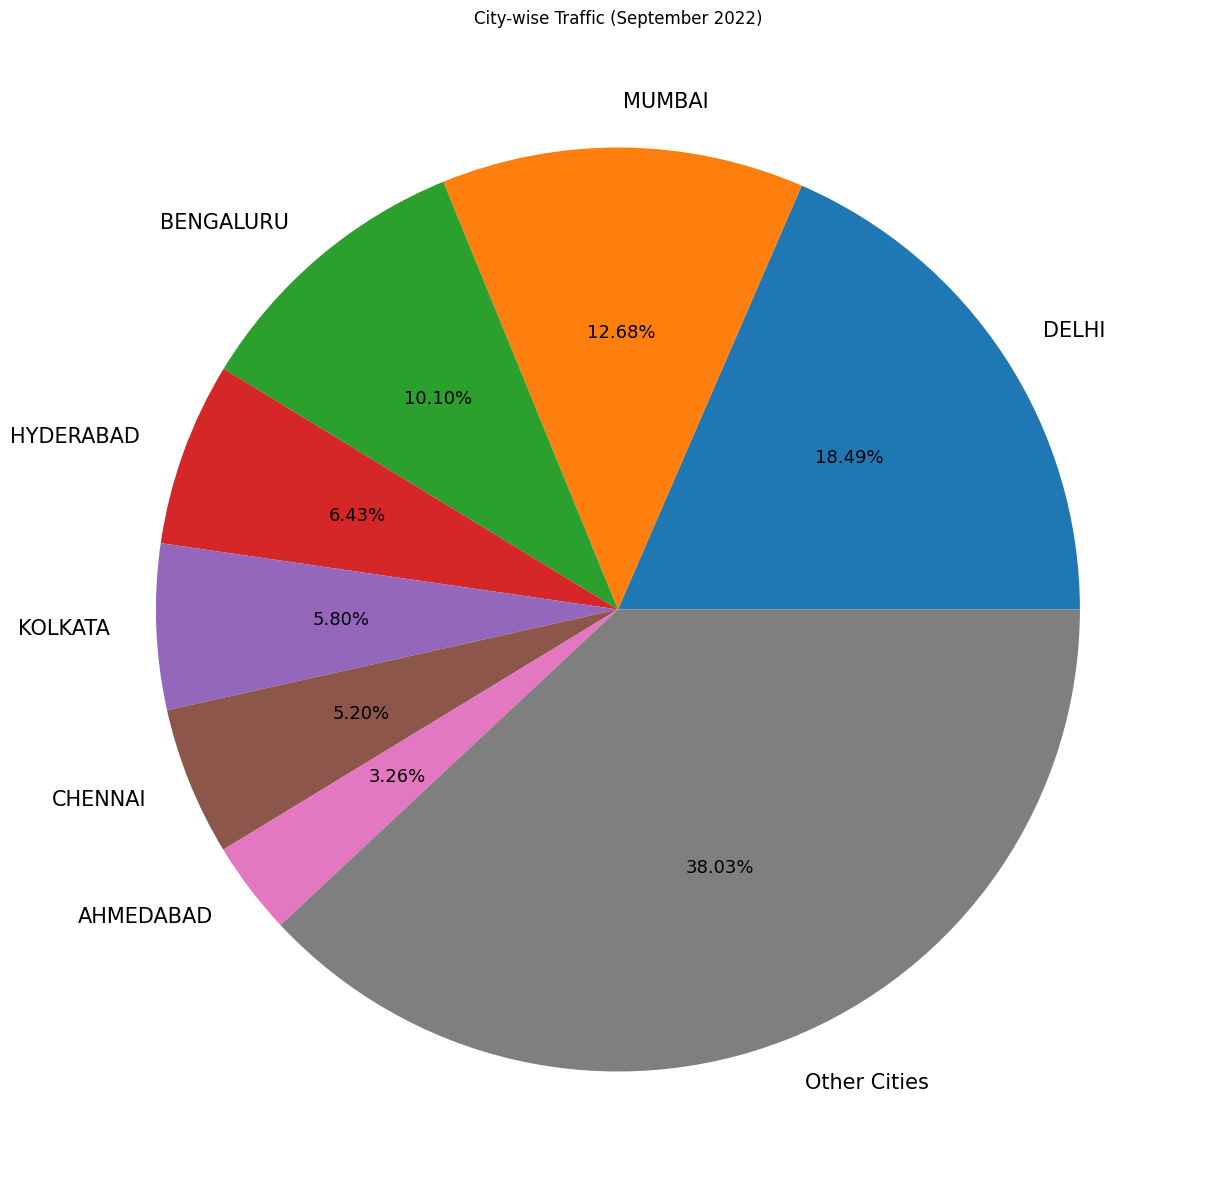

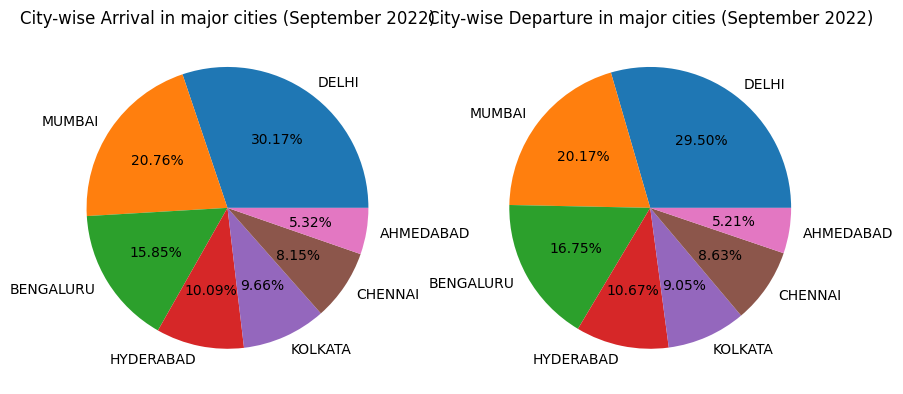

In [112]:
func1('september2022.csv','September 2022')

Busiest route in October 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
265  DELHI  MUMBAI               4110


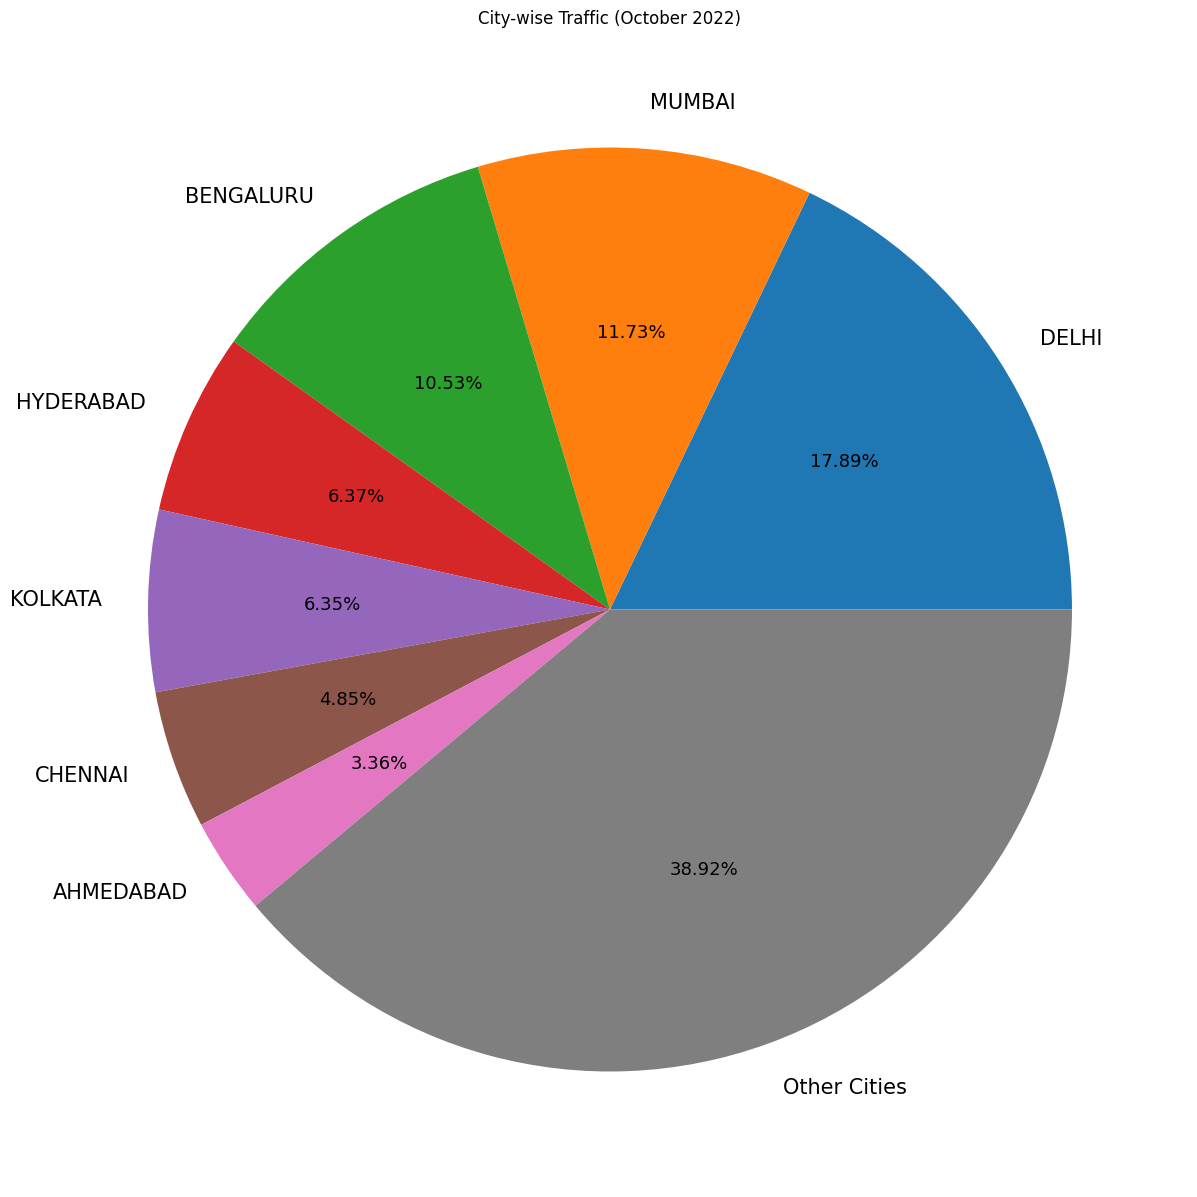

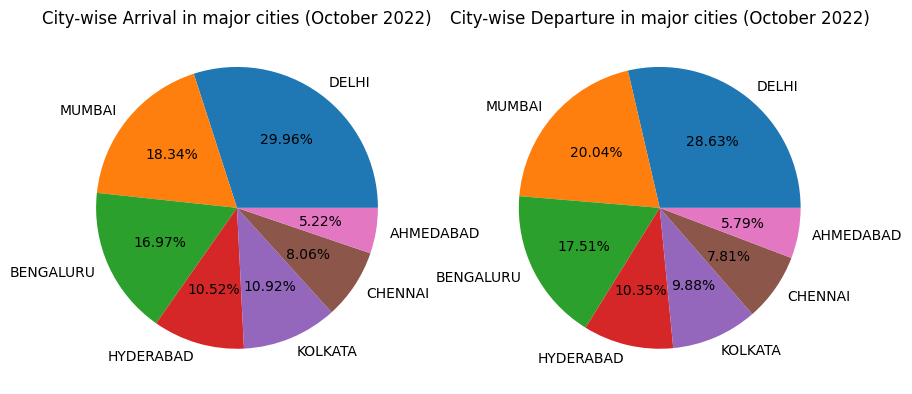

In [113]:
func1('october2022.csv','October 2022')

Busiest route in November 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
328  DELHI  MUMBAI               4492


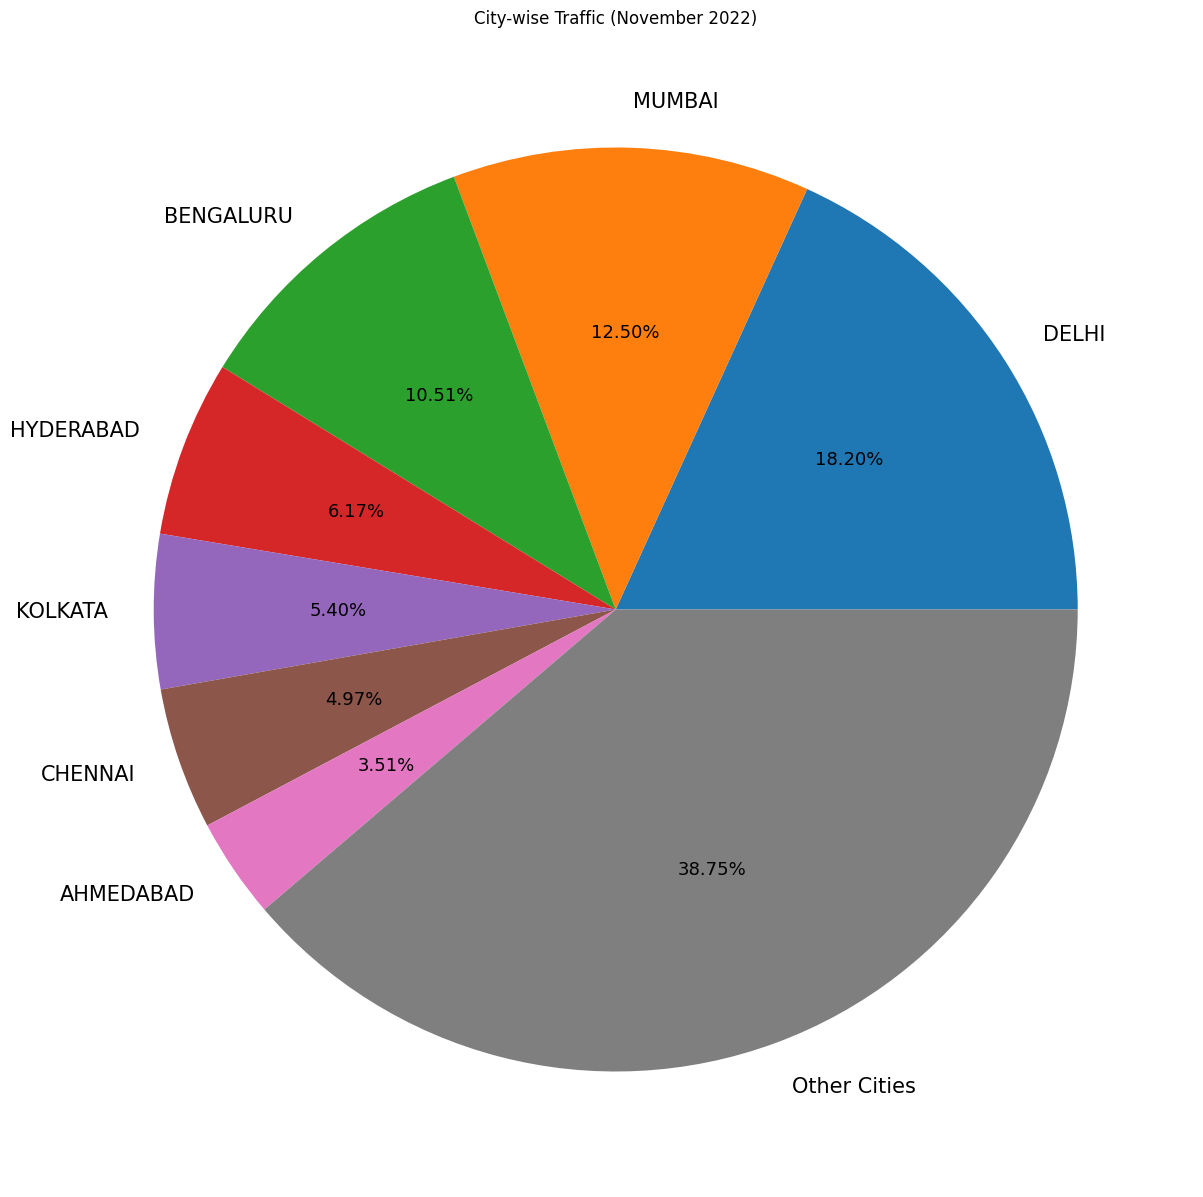

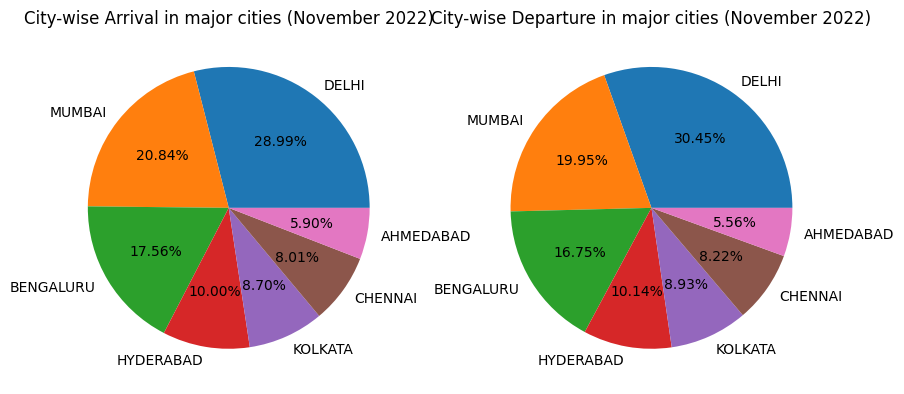

In [114]:
func1('november2022.csv','November 2022')

Busiest route in December 2022:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
323  DELHI  MUMBAI               4835


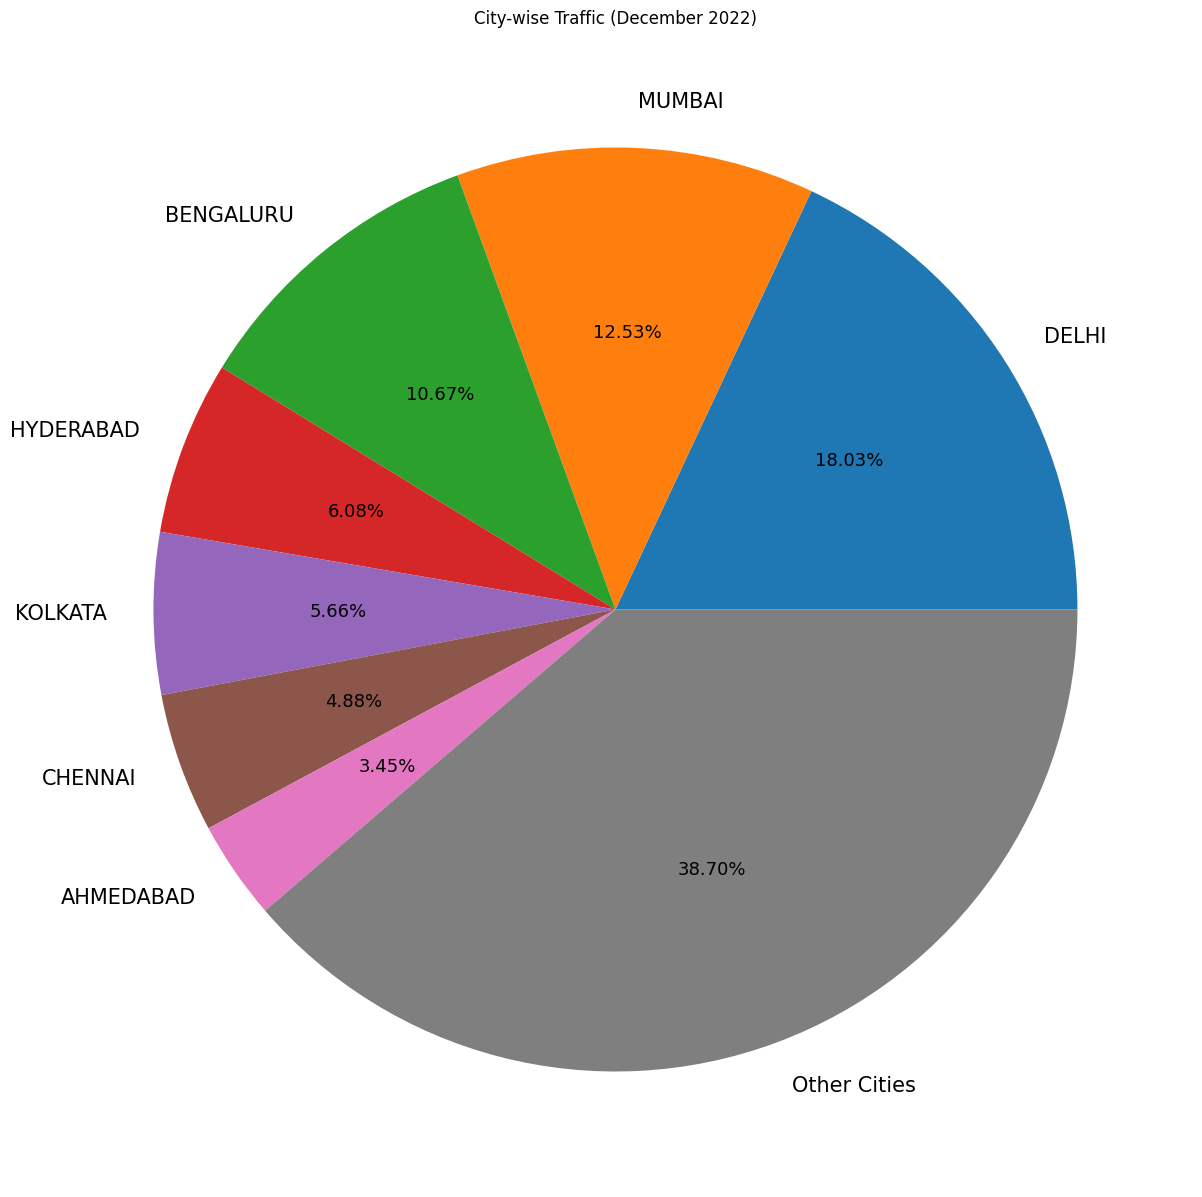

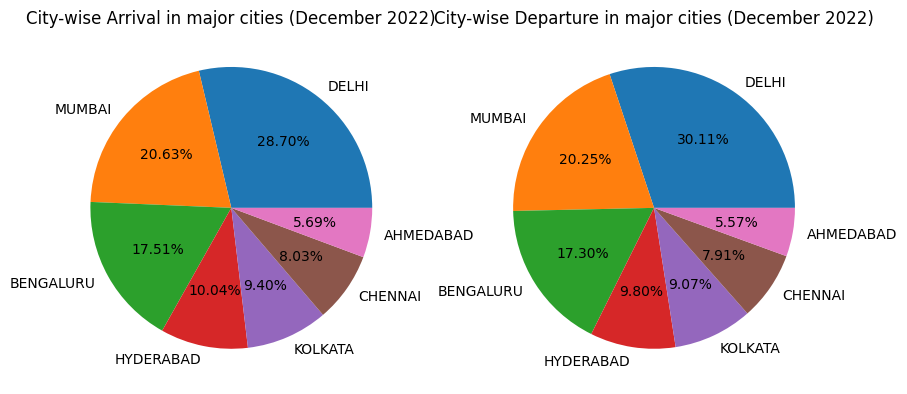

In [115]:
func1('december2022.csv','December 2022')

Busiest route in 2022 Q1:
    CITY 1 CITY 2  TOTAL AVG FLIGHTS
102  DUBAI  DELHI               2545


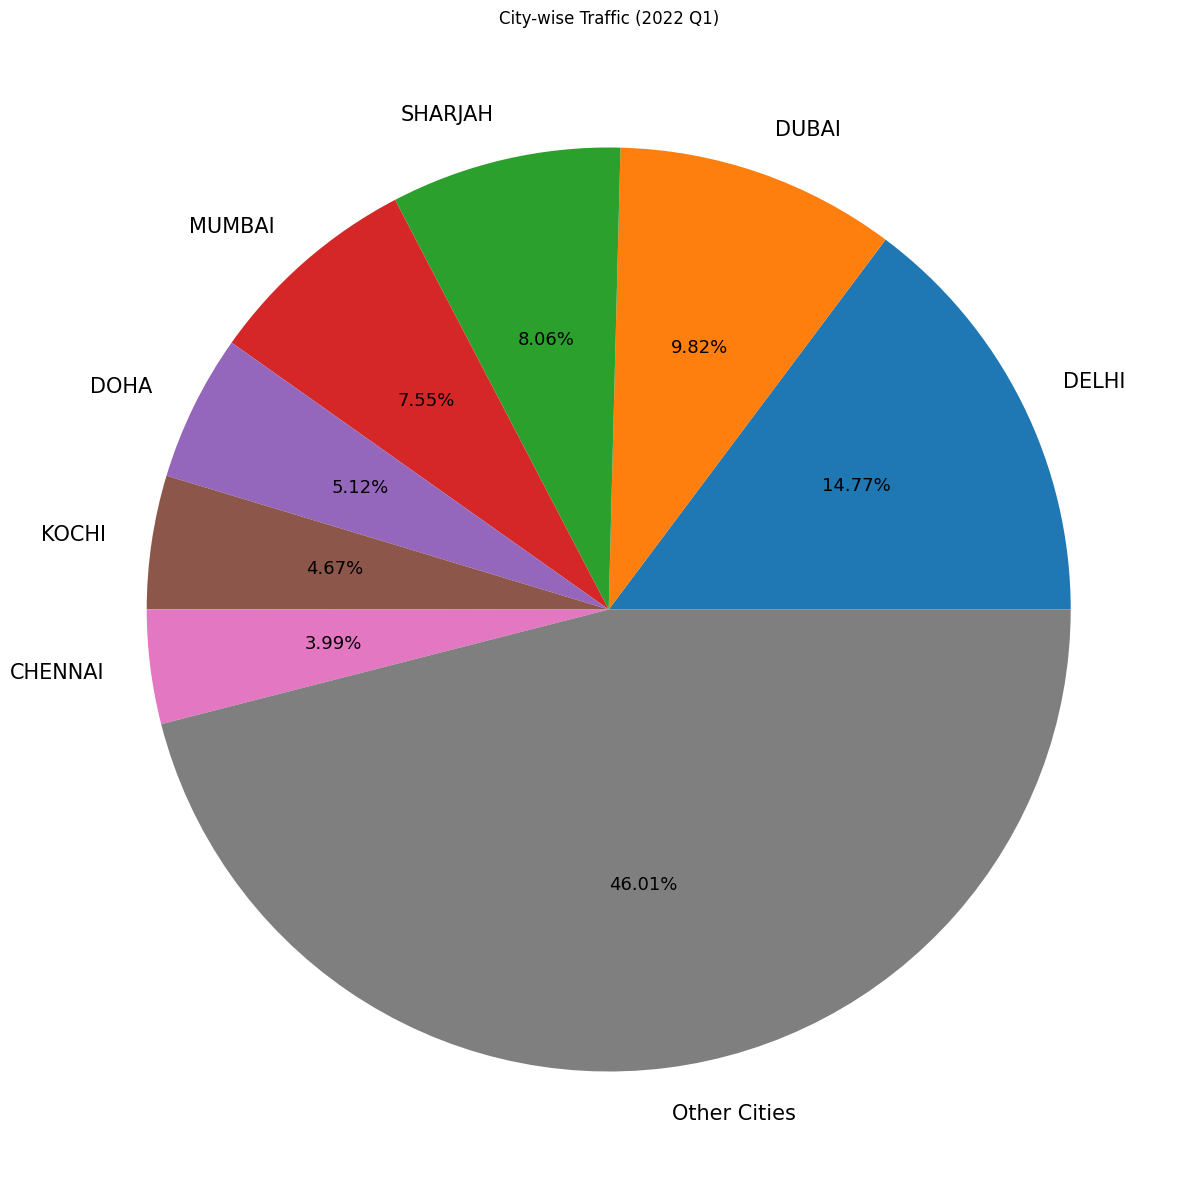

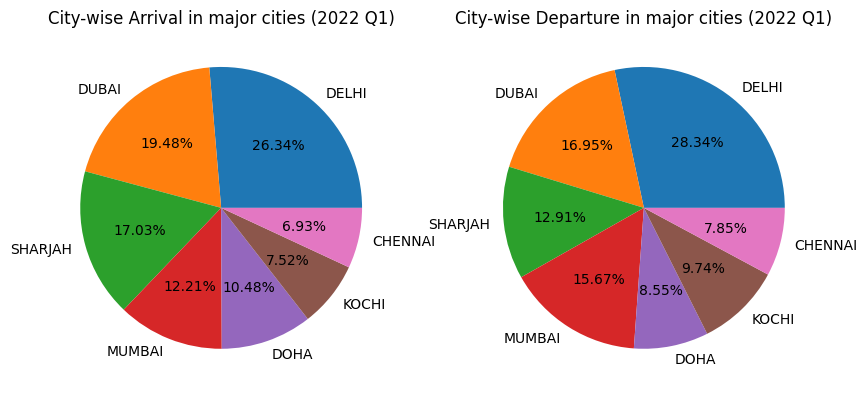

In [116]:
func1('22Q1.csv','2022 Q1')

Busiest route in 2022 Q2:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
101  DUBAI  MUMBAI               4728


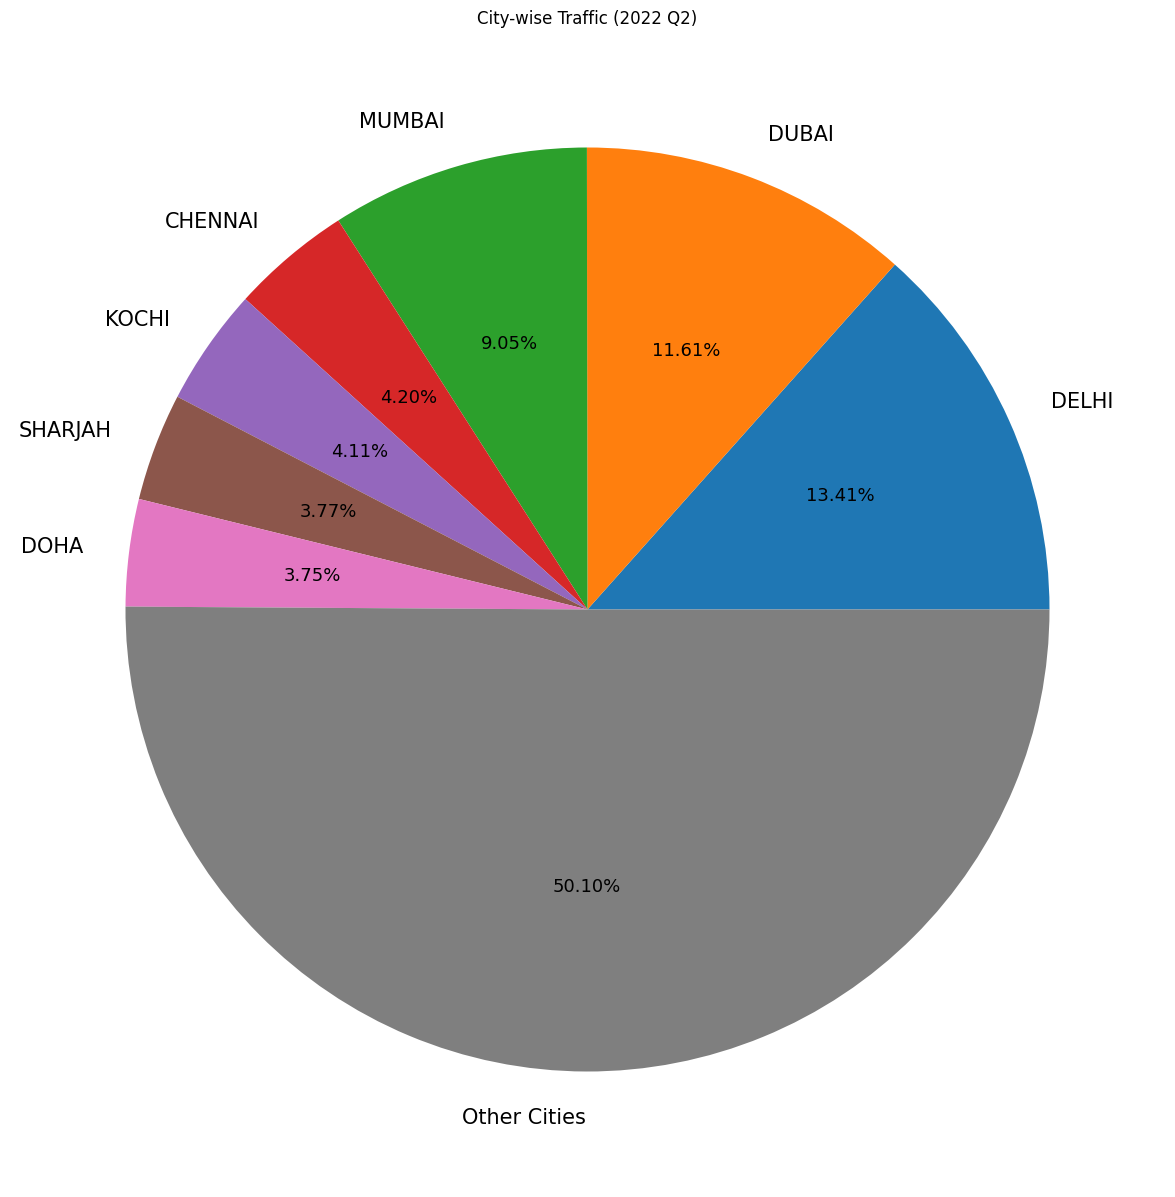

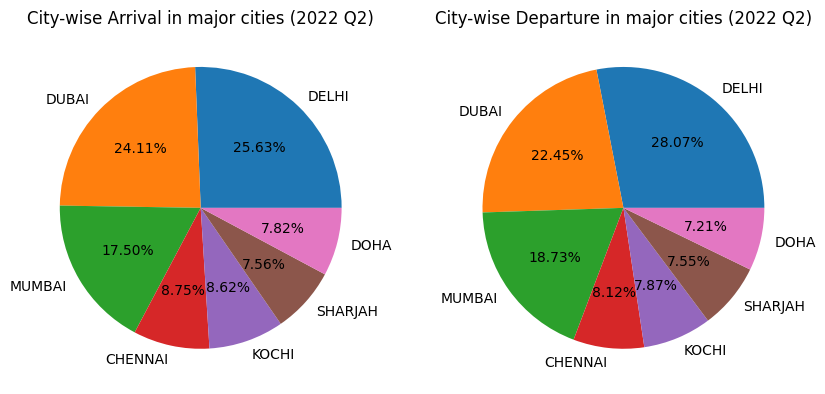

In [117]:
func1('22Q2.csv','2022 Q2')

Busiest route in 2022 Q3:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
106  DUBAI  MUMBAI               4951


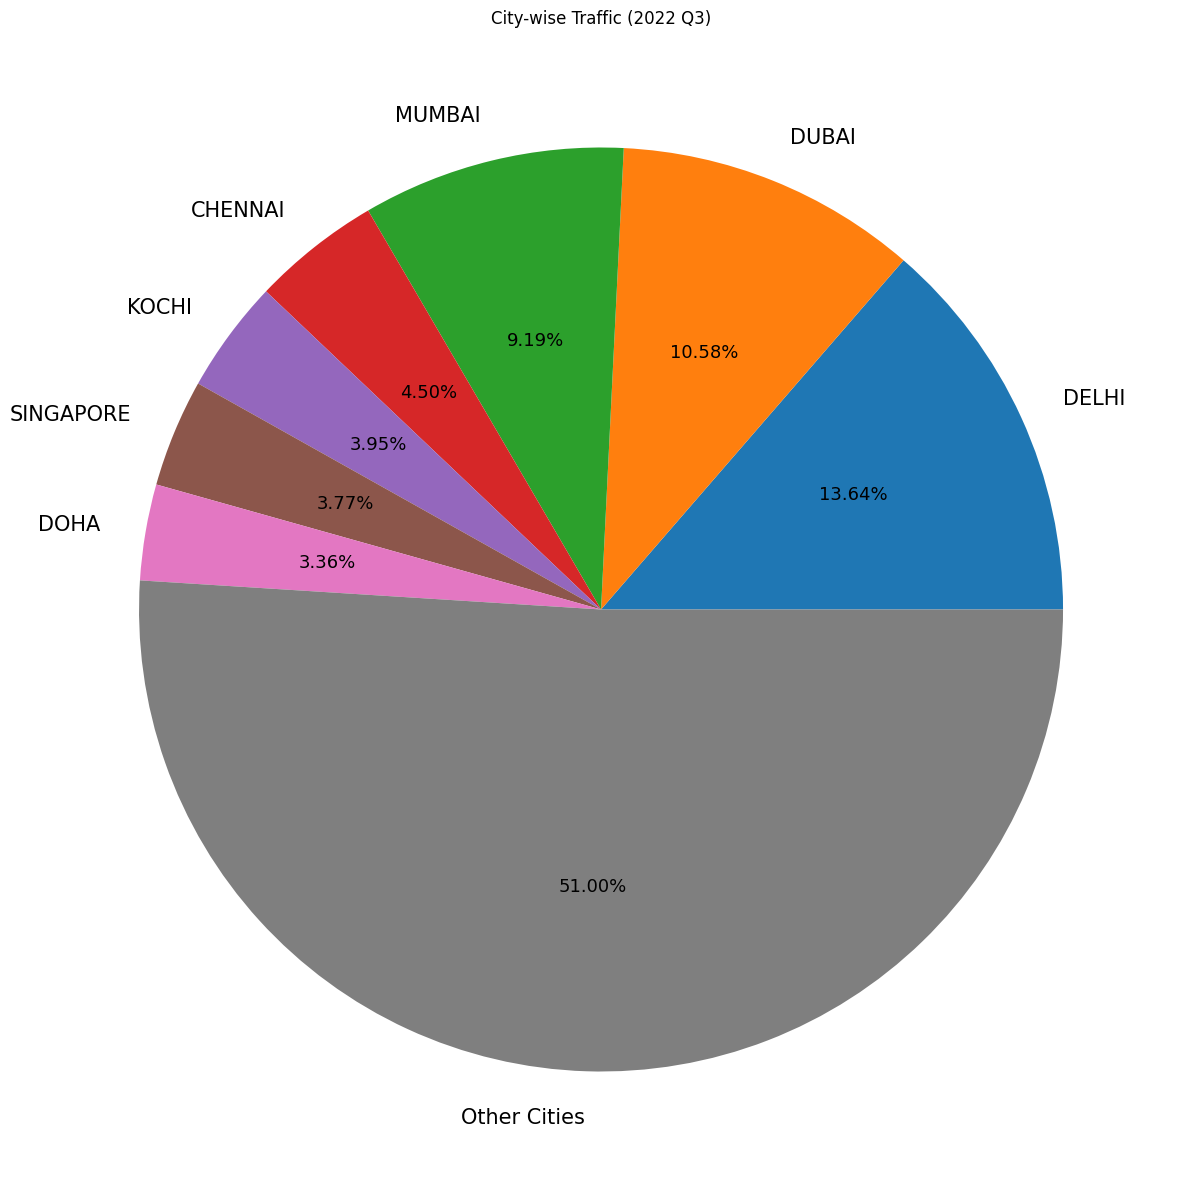

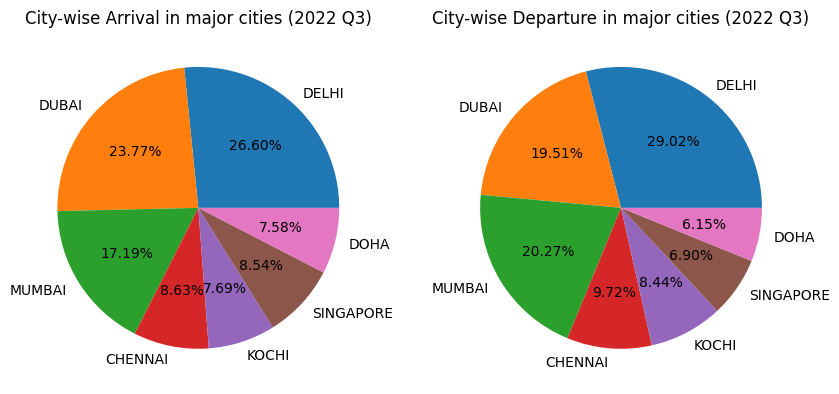

In [118]:
func1('22Q3.csv','2022 Q3')

Busiest route in 2022 Q4:
    CITY 1  CITY 2  TOTAL AVG FLIGHTS
118  DUBAI  MUMBAI               5560


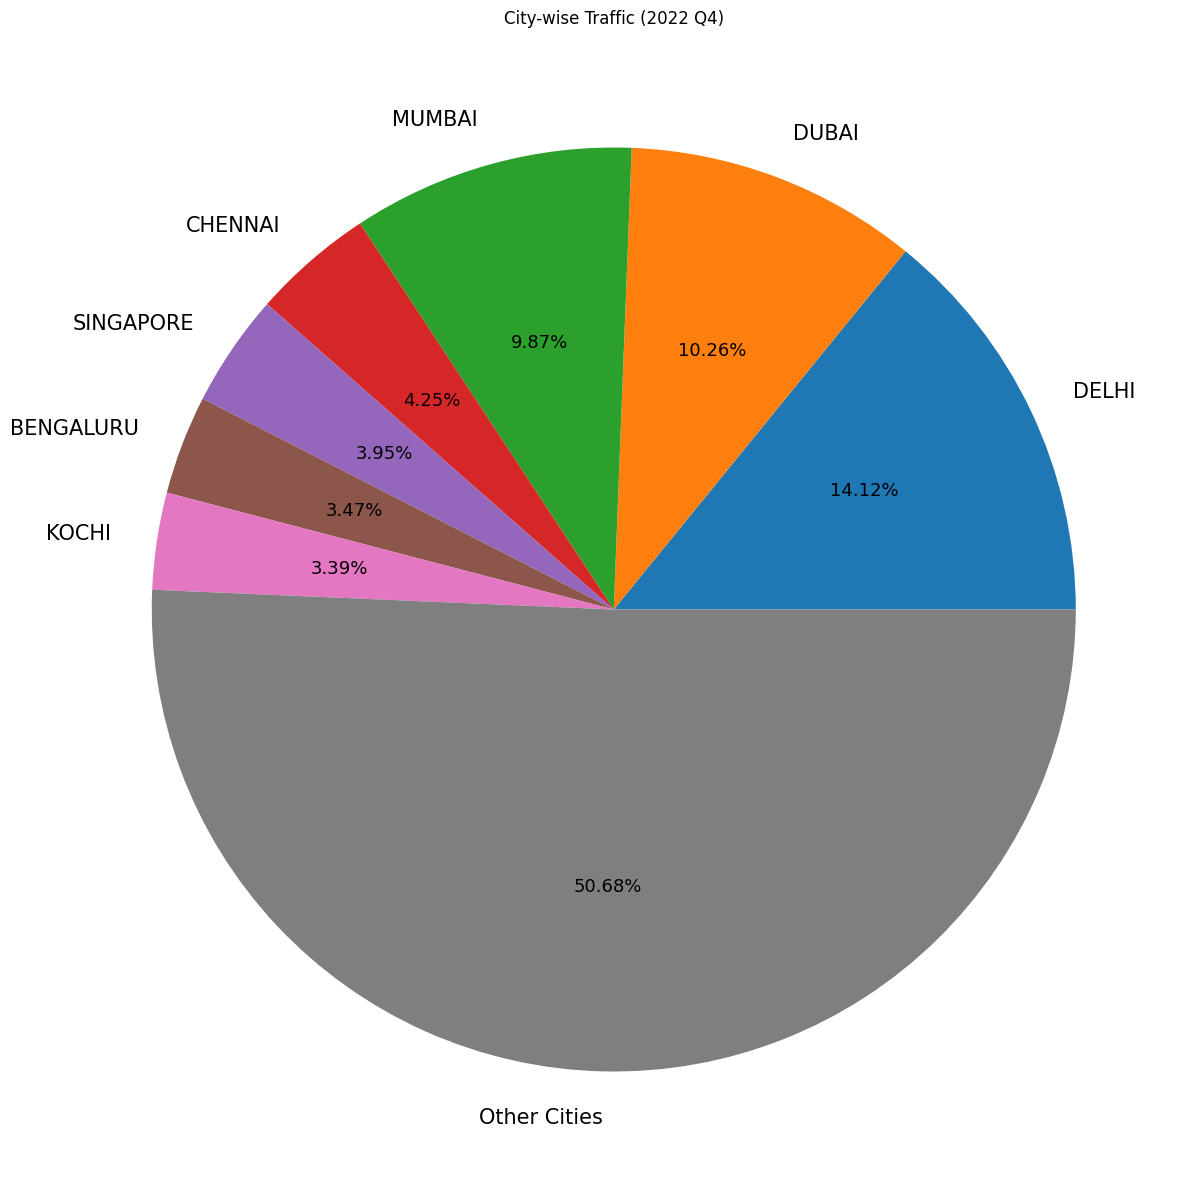

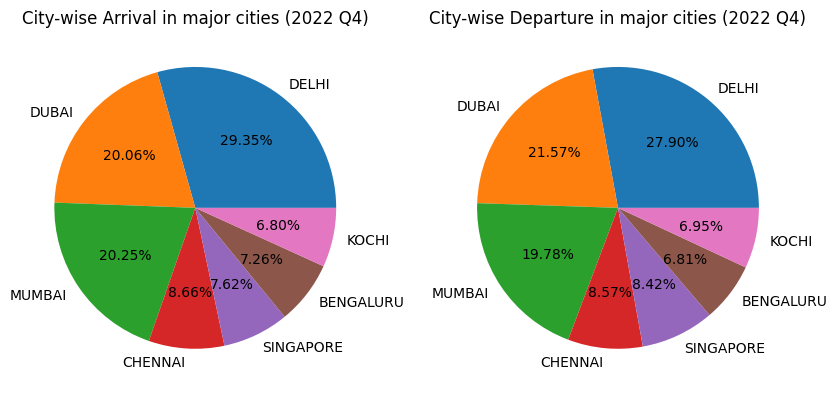

In [119]:
func1('22Q4.csv','2022 Q4')